In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func 

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Display the row's columns and data in dictionary format
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x120fa8278>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
# Display the row's columns and data in dictionary format
station_first_row = session.query(Station).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x120fb4208>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

query_latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()# latest Date
dt_latest_date = dt.datetime.strptime(query_latest_date[0], '%Y-%m-%d')# latest Date in datetime format

#calculate year ago date
year_ago_date = dt_latest_date - dt.timedelta(days=365)
print("latest date:",dt_latest_date,"\n12 months ago date:",year_ago_date)

latest date: 2017-08-23 00:00:00 
12 months ago date: 2016-08-23 00:00:00


In [14]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = (session
 .query(Measurement.date,Measurement.prcp)
 .filter(Measurement.date > year_ago_date)
 .filter(Measurement.prcp>=0)
 .order_by(Measurement.date).all())
prcp_data

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.02),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.05),
 ('2016-08-31', 0.13),
 ('2016-08-31', 0.1),
 ('

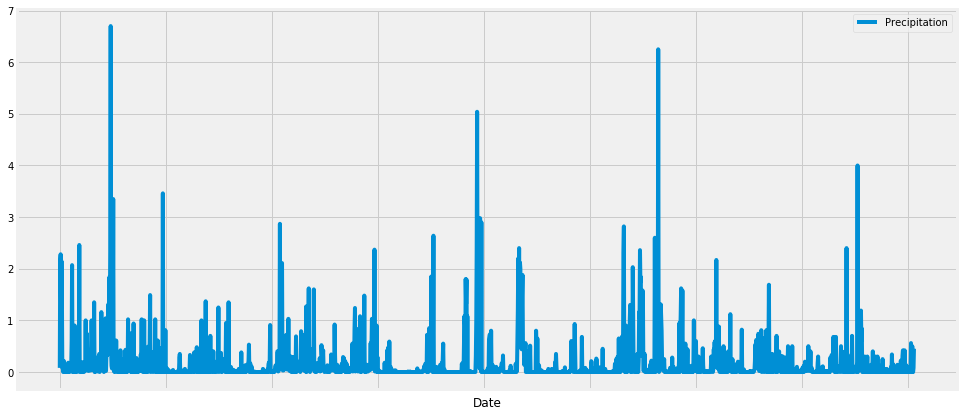

In [24]:
# Plot the Results 
#------------------------------------------
df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.plot(figsize=(15,7))

In [25]:
#1 Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
#2  Use Pandas to calcualte the summary statistics for the precipitation data 
max_prcp_date= df[df['Precipitation']==df['Precipitation'].max()].index[0]
max_prcp=df['Precipitation'].max()
min_prcp=df['Precipitation'].min()
avg_prcp=df['Precipitation'].mean()
std_prcp=df['Precipitation'].std()
count_prcp=df['Precipitation'].count()
summary = pd.DataFrame({"Max Prcp Date": max_prcp_date,
                              "Max Prcp": max_prcp,
                              "Min Prcp": min_prcp,
                              "Average Prcp": avg_prcp,
                              "Std Prcp": std_prcp,
                              "Total Days": count_prcp,
                              },index=["Summary"])
summary

,Max Prcp Date,Max Prcp,Min Prcp,Average Prcp,Std Prcp,Total Days
Summary,2016-09-14,6.7,0.0,0.176462,0.460288,2015


In [27]:
# Design a query to show how many stations are available in this dataset?
from sqlalchemy import distinct
total_stations = (session
 .query(func.count(distinct(Measurement.station)))
 .all())
total_stations

[(9)]

In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_list = (session
 .query(Measurement.station, func.count(Measurement.station))
 .group_by(Measurement.station)
 .order_by(func.count(Measurement.station).desc())
 .all())
stations_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tobs_stat = (session
 .query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))
 .all())
print("Min Tobs:",tobs_stat[0][0],"\nMax Tobs:",tobs_stat[0][1],"\nAvg Tobs:",tobs_stat[0][2])

Min Tobs: 53.0 
Max Tobs: 87.0 
Avg Tobs: 73.09795396419437


In [30]:
# Choose the station with the highest number of temperature observations.
station_max_no_of_tobs = stations_list[0][0]
station_max_no_of_tobs 

'USC00519281'

In [31]:
# Query the last 12 months of temperature observation data for this station
tobs_data = (session
 .query(Measurement.tobs)
 .filter(Measurement.date > year_ago_date)
 .filter(Measurement.station==station_max_no_of_tobs )
 .order_by(Measurement.tobs).all())

Text(0,0.5,'Frequency')

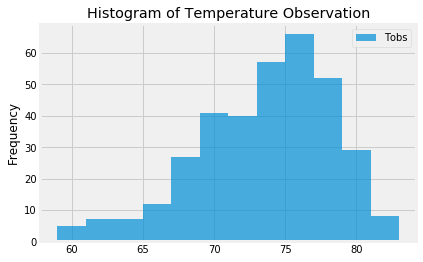

In [32]:
#plot the results as a histogram
df = pd.DataFrame(tobs_data, columns=['Tobs'])
df.plot.hist(bins=12, alpha=0.7)
plt.title("Histogram of Temperature Observation")
#plt.xlabel("Tobs")
plt.ylabel("Frequency")

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates."""
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps = calc_temps('2012-02-28', '2012-03-05')
tmin = temps[0][0]
tavg = temps[0][1]
tmax = temps[0][2]
print("tmin: ",tmin,"\ntavg: ",tavg,"\ntmax: ",tmax)

tmin:  62.0 
tavg:  69.57142857142857 
tmax:  74.0


Text(0,0.5,'Average Temperature')

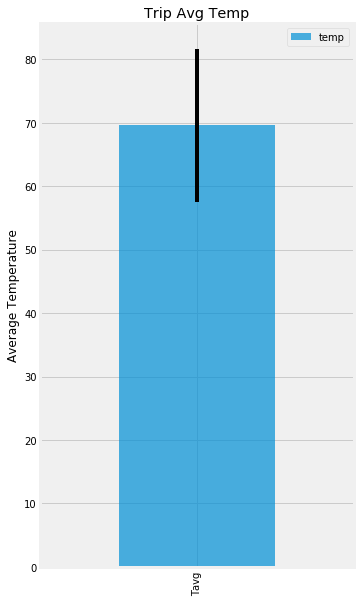

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame({'name':['Tavg',], "temp":[tavg]})
df.plot.bar(x='name', y='temp', yerr=tmax-tmin,figsize=(5,10),alpha=0.7)
plt.title("Trip Avg Temp")
plt.xlabel("")
plt.ylabel("Average Temperature")

# Optional Challenge Assignment

In [36]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall_per_station_from_previous_year_by_date(trip_date):
    dt_prev_year_date = dt.datetime.strptime(trip_date, '%Y-%m-%d') - dt.timedelta(days=365)
    prev_year_date=dt_prev_year_date.strftime("%Y-%m-%d")

    prcp_data = (session
     .query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.prcp)
     .join(Station, Measurement.station ==Station.station)
     .filter(Measurement.date == prev_year_date)
     #.filter(Measurement.prcp>=0)
     .group_by(Measurement.station)
     .order_by(Measurement.prcp.desc()).all())
    df = pd.DataFrame(prcp_data, columns=['Station', 'Name','Latitude','Longitude','Elevation','Precipitation'])
    df.set_index('Station', inplace=True)
    return (df)

rainfall_per_station_from_previous_year_by_date('2017-08-23')


,Name,Latitude,Longitude,Elevation,Precipitation
Station,,,,,
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.79
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.70
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.15
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.05
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.02
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    #Args: date (str): A date string in the format '%m-%d'
    #Returns: A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
def normals_start_end_date(start_date, end_date):
    normals=[]
    start_end_date_list =[]
    dt1 = dt.datetime.strptime(start_date, '%Y-%m-%d')
    dt2 = dt.datetime.strptime(end_date, '%Y-%m-%d')
    delta = dt2 - dt1

    for i_day in range(delta.days + 1):
        date = dt1 + dt.timedelta(i_day)
        start_end_date_list.append(date)
    
        date_m_d = (dt1 + dt.timedelta(i_day)).strftime("%m-%d")
        normals.append(daily_normals(date_m_d)[0])
        
    return start_end_date_list, normals

In [39]:
date_list, normals = normals_start_end_date('2018-01-01','2018-01-05')
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0)]

In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(np.column_stack([date_list,normals]), columns=['Date', 'Tmin', 'Tavg','Tmax'])
df.set_index('Date', inplace=True)
df


,Tmin,Tavg,Tmax
Date,,,
2018-01-01,62,69.1538,77
2018-01-02,60,69.3962,77
2018-01-03,62,68.9091,77
2018-01-04,58,70,76
2018-01-05,56,67.9643,76


Text(0,0.5,'Temperature (F)')

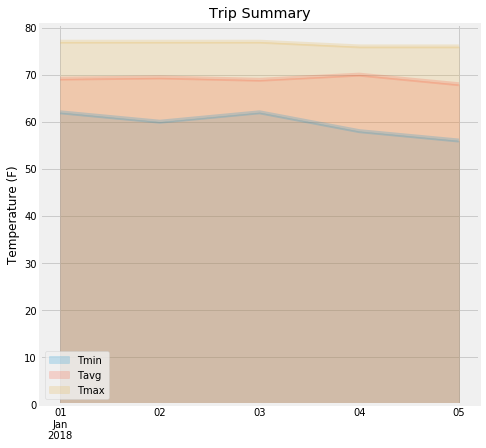

In [41]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False,figsize=(7,7), alpha=0.2)
plt.grid(True)
plt.title("Trip Summary")
plt.xlabel("")
plt.ylabel("Temperature (F)")